full CAE classifiaction script

CAE with 3 convolution and 3 deconvolution layers (no pooling)

trained for 50 epochs

classifier: threshold based on train data features

best classification results (on test data) - after 20 epochs:

    Accuracy: 0.6760
    Precision: 0.6099
    Recall: 0.7679
    F1 Score: 0.6798 

reconstruction error heatmaps for visualisation

In [2]:
# Import libraries
from torchmetrics import StructuralSimilarityIndexMeasure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_fscore_support
from torch.utils.data import Subset
import random

In [3]:
# Set random seed for reproducibility
SEED = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
# Dataset paths
train_dir = "../../linsen_data/train"
test_dir = "../../linsen_data/test"

# Extra preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),    # Resize the image to 128x128 for ligher computation
    transforms.ToTensor(),
])

# Load train data
train_dataset = datasets.ImageFolder(root='../../linsen_data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Number of images in train:", len(train_dataset))

# Filter for class 0 ("good") for CAE training
target_class = 0  
filtered_indices = [i for i, (_, label) in enumerate(train_dataset) if label == target_class]
cae_train_dataset = Subset(train_dataset, filtered_indices)
cae_train_loader = DataLoader(cae_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Number of images in train (class {target_class}):", len(cae_train_dataset))

# Load test data
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Number of images in train: 1404
Number of images in train (class 0): 750


In [ ]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 16 * 16, 256)  

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Decoder Model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(256, 128 * 16 * 16)  
        self.unflatten = nn.Unflatten(1, (128, 16, 16))  

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Setup 
autoencoder = Autoencoder()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# MSE loss with Variance Minimization Regularization
def mse_loss_with_variance_regularization(reconstructed, original, encoded, lambda_reg=0.1):
    mse_loss = nn.MSELoss()(reconstructed, original)
    encoded_variance = torch.var(encoded.view(encoded.size(0), -1), dim=1).mean()
    reg_loss = lambda_reg * encoded_variance
    total_loss = mse_loss + reg_loss
    return total_loss

In [7]:
# Checkpoint save function
def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, filename)

In [ ]:
# Training Loop
# (skip if loading from checkpoint)
lambda_reg = 0.1  # Regularization strength

epoch_losses = []

for epoch in range(EPOCHS):
    autoencoder.train()  
    
    running_loss = 0.0
    
    for inputs, _ in cae_train_loader:
        inputs = inputs.to(device)  
        
        reconstructed = autoencoder(inputs)
        encoded = autoencoder.encoder(inputs)

        loss = mse_loss_with_variance_regularization(reconstructed, inputs, encoded, lambda_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)  

    save_checkpoint(autoencoder, optimizer, epoch, f'cae_nopool_epoch_{epoch}.pth')
    
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), epoch_losses, marker='o', color='b', label='Reconstruction Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
cae = autoencoder

In [ ]:
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded: epoch {epoch}")
    return epoch  


In [ ]:
# Load saved CAE model

autoencoder_checkpoint_path = "cae_nopool_epoch_19.pth"

cae = Autoencoder().to(DEVICE)

load_checkpoint(model=cae, optimizer=None, checkpoint_path=autoencoder_checkpoint_path)

Checkpoint loaded: epoch 19


19

Visualizing training data:


/var/folders/8_/f8kmzr5j715637z3t60_pjqm0000gn/T/ipykernel_13325/1168634302.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


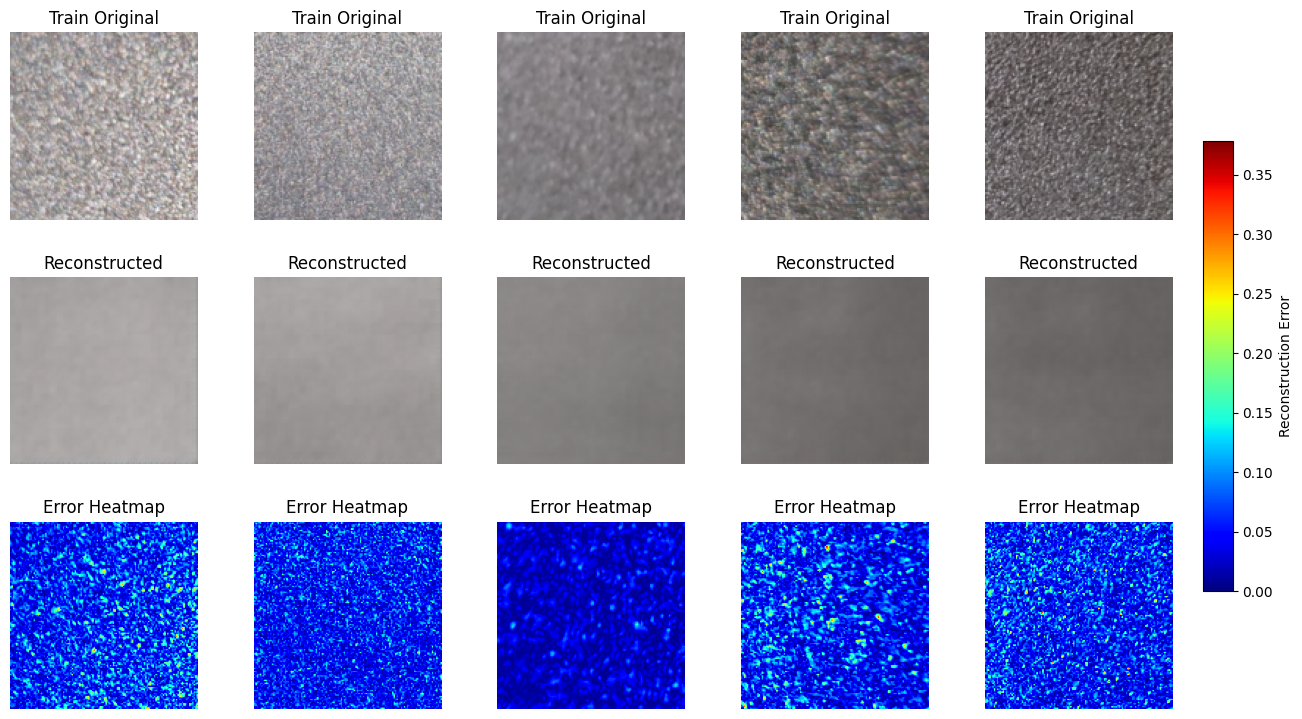

Visualizing good test data:


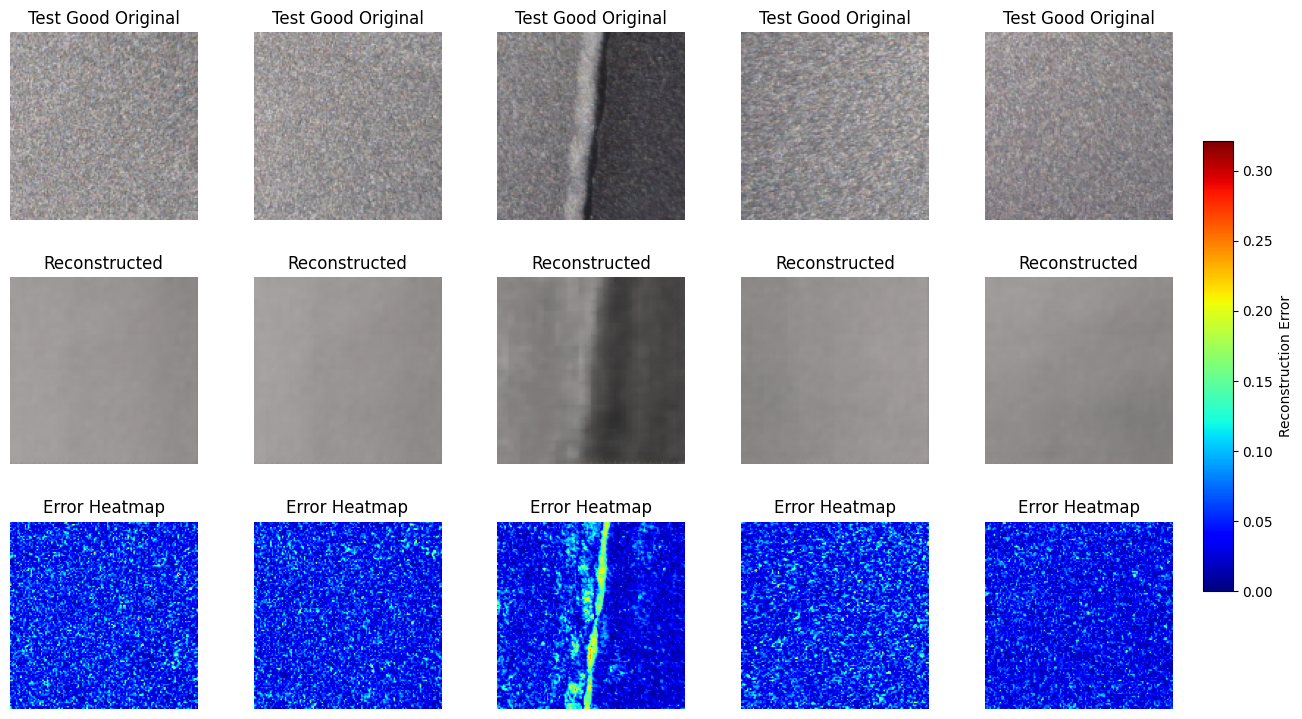

Visualizing bad test data:


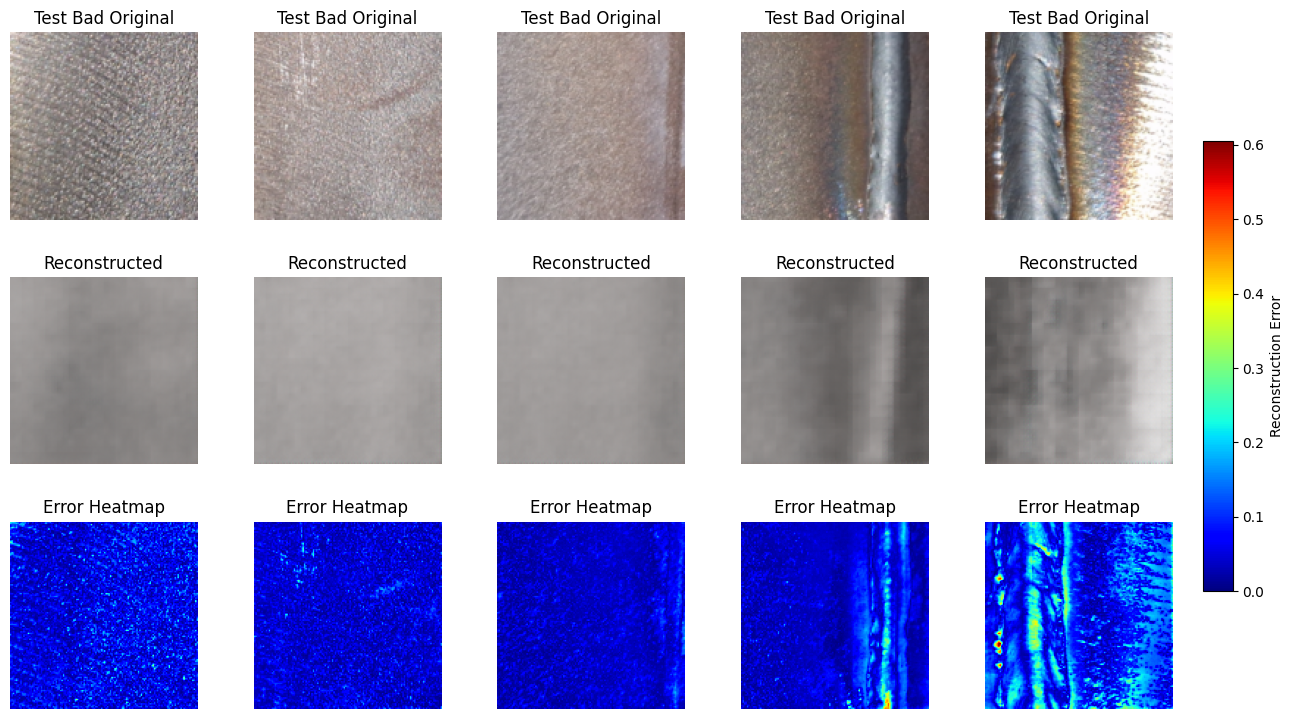

In [ ]:
# Plot original, reconstruction, error heatmap for random good images from dataloader
def visualize_autoencoder_performance(autoencoder, data_loader, num_samples=5, title_prefix=""):
    autoencoder.eval() 
    images, labels = next(iter(data_loader))  
    selected_indices = random.sample(range(len(images)), num_samples)  
    images = images[selected_indices].to(DEVICE)  
    
    with torch.no_grad():
        reconstructions = autoencoder(images)  
        errors = torch.abs(images - reconstructions)  

    images_np = images.cpu().permute(0, 2, 3, 1).numpy()  
    reconstructions_np = reconstructions.cpu().permute(0, 2, 3, 1).numpy()
    errors_np = errors.cpu().permute(0, 2, 3, 1).numpy()

    max_error = errors_np.mean(axis=-1).max()  

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9), gridspec_kw={'width_ratios': [1]*num_samples, 'wspace': 0.3})

    for i in range(num_samples):
        axes[0, i].imshow(images_np[i])  
        axes[0, i].set_title(f"{title_prefix} Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructions_np[i])  
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

        im = axes[2, i].imshow(errors_np[i].mean(axis=-1), cmap="jet", vmin=0, vmax=max_error)
        axes[2, i].set_title("Error Heatmap")
        axes[2, i].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  
    fig.colorbar(im, cax=cbar_ax, label="Reconstruction Error")
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  
    plt.show()

print("Visualizing training data:")
visualize_autoencoder_performance(cae, cae_train_loader, num_samples=5, title_prefix="Train")

print("Visualizing good test data:")
visualize_autoencoder_performance(cae, test_loader, num_samples=5, title_prefix="Test Good")

print("Visualizing bad test data:")
test_bad_loader = DataLoader(
    Subset(test_dataset, [i for i, (_, label) in enumerate(test_dataset) if label != target_class]),
    batch_size=BATCH_SIZE,
    shuffle=False
)
visualize_autoencoder_performance(cae, test_bad_loader, num_samples=5, title_prefix="Test Bad")

In [ ]:
# For classification

def compute_threshold(features_train, C):
    V_mean = features_train.mean(dim=0)
    distances = torch.norm(features_train - V_mean, dim=1)
    mu_d = distances.mean()
    sigma_d = distances.std()
    Td = mu_d + C * sigma_d
    return Td, V_mean

def classify_anomaly(feature_test, V_mean, Td):
    dI = torch.norm(feature_test - V_mean)
    return "Defective" if dI > Td else "Defect-Free"

In [ ]:
# Extract Features from Training Data
print("Extracting features from training data...")
features_train = []
with torch.no_grad():
    for images, _ in cae_train_loader:
        images = images.to(DEVICE)
        features = cae.encoder(images)
        features = features.view(features.size(0), -1)  
        features_train.append(features)
features_train = torch.cat(features_train, dim=0)

# Control Limit Constant
C = 0.01

# Compute Threshold
Td, V_mean = compute_threshold(features_train, C)
print(f"Threshold (Td): {Td:.4f}")

Extracting features from training data...
Threshold (Td): 0.2380


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Evaluate classification performance (accuracy, precision, recall, F1 score) on test data, overall and per class
def evaluate_model(test_loader, cae, V_mean, Td, device):

    # Get predictions
    y_true = []  
    y_pred = []  

    cae.eval()  
    with torch.no_grad():
        for images, labels_batch in test_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)

            features = cae.encoder(images).view(images.size(0), -1)  

            for i in range(features.size(0)):  
                dI = torch.norm(features[i] - V_mean)  
                prediction = 1 if dI > Td else 0  
                y_pred.append(prediction)
                y_true.append(labels_batch[i].item())

    # Calculate overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)  
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    # Calculate metrics per class
    categories = ['Ready for Paint', 'Needs Shot Blasting']  

    precision_list = []
    recall_list = []
    f1_list = []

    for label in [0, 1]:
        precision_class = precision_score(y_true, y_pred, labels=[label], average='binary', pos_label=label, zero_division=0)
        recall_class = recall_score(y_true, y_pred, labels=[label], average='binary', pos_label=label, zero_division=0)
        f1_class = f1_score(y_true, y_pred, labels=[label], average='binary', pos_label=label, zero_division=0)
        
        precision_list.append(precision_class)
        recall_list.append(recall_class)
        f1_list.append(f1_class)

    results_table = pd.DataFrame({
        'Category': categories,
        'Precision': precision_list,
        'Recall': recall_list,
        'F1-Score': f1_list
    })

    accuracy_row = pd.DataFrame({'Category': ['Accuracy'], 'Precision': [""], 'Recall': [""], 'F1-Score': [accuracy]})
    results_table = pd.concat([results_table, accuracy_row], ignore_index=True)

    return metrics, results_table


metrics, results_table = evaluate_model(test_loader, cae, V_mean, Td, device)

print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")

print(results_table)


Accuracy: 0.6760
Precision: 0.6099
Recall: 0.7679
F1 Score: 0.6798
              Category Precision    Recall  F1-Score
0      Ready for Paint  0.761468  0.601449  0.672065
1  Needs Shot Blasting  0.609929  0.767857  0.679842
2             Accuracy                      0.676000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot CAE reconstructions and heatmaps for the confusion matrix
def evaluate_model(test_loader, cae, V_mean, Td, device):
    cae.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            reconstructions = cae(images)
            features = cae.encoder(images).view(images.size(0), -1)
            
            for i in range(images.size(0)):
                dI = torch.norm(features[i] - V_mean)
                prediction = 1 if dI > Td else 0
                
                original = images[i].cpu().numpy().transpose(1, 2, 0)
                reconstructed = reconstructions[i].cpu().numpy().transpose(1, 2, 0)
                error_map = np.abs(original - reconstructed).mean(axis=2)
                
                if labels[i] == 1 and prediction == 1:
                    classification = "True Positive (TP)"
                elif labels[i] == 0 and prediction == 1:
                    classification = "False Positive (FP)"
                elif labels[i] == 1 and prediction == 0:
                    classification = "False Negative (FN)"
                else:
                    classification = "True Negative (TN)"
                
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                fig.suptitle(classification, fontsize=14)
                
                ax[0].imshow(original, cmap='gray')
                ax[0].set_title("Original")
                ax[0].axis("off")
                
                ax[1].imshow(reconstructed, cmap='gray')
                ax[1].set_title("Reconstruction")
                ax[1].axis("off")
                
                ax[2].imshow(error_map, cmap='jet')
                ax[2].set_title("Error Map")
                ax[2].axis("off")
                
                plt.show()
evaluate_model(test_loader, cae, V_mean, Td, DEVICE)